# Phân tích EDA Chi tiết - Beijing Air Quality Dataset

**Mục tiêu:** Kiểm tra đầy đủ các thành phần để hiểu dữ liệu:
1. Kiểm tra khoảng thời gian và tần suất dữ liệu
2. Phân tích dữ liệu thiếu theo biến và thời gian
3. Phát hiện outliers và phân phối
4. Trực quan hóa chuỗi thời gian PM2.5
5. Kiểm tra tự tương quan
6. Kiểm tra tính dừng (stationarity)
7. Phân tích biến thiếu quan trọng cho dự báo

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.stattools import adfuller, kpss

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [3]:
# Load cleaned data
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data/processed/cleaned.parquet'

df = pd.read_parquet(data_path)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (420768, 55)

Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24']


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,PM10_lag24,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Kiểm tra khoảng thời gian và tần suất dữ liệu

In [4]:
print("=" * 70)
print("KHOẢNG THỜI GIAN DỮ LIỆU")
print("=" * 70)

print(f"\nNgày bắt đầu: {df['datetime'].min()}")
print(f"Ngày kết thúc: {df['datetime'].max()}")
print(f"Tổng thời gian: {(df['datetime'].max() - df['datetime'].min()).days} ngày")
print(f"                ({(df['datetime'].max() - df['datetime'].min()).days / 365:.2f} năm)")

print(f"\nSố trạm quan trắc: {df['station'].nunique()}")
print(f"Các trạm: {', '.join(df['station'].unique())}")

# Số quan sát theo trạm
print("\nSố quan sát theo trạm:")
print(df['station'].value_counts().sort_index())

KHOẢNG THỜI GIAN DỮ LIỆU

Ngày bắt đầu: 2013-03-01 00:00:00
Ngày kết thúc: 2017-02-28 23:00:00
Tổng thời gian: 1460 ngày
                (4.00 năm)

Số trạm quan trắc: 12
Các trạm: Aotizhongxin, Changping, Dingling, Dongsi, Guanyuan, Gucheng, Huairou, Nongzhanguan, Shunyi, Tiantan, Wanliu, Wanshouxigong

Số quan sát theo trạm:
station
Aotizhongxin     35064
Changping        35064
Dingling         35064
Dongsi           35064
Guanyuan         35064
Gucheng          35064
Huairou          35064
Nongzhanguan     35064
Shunyi           35064
Tiantan          35064
Wanliu           35064
Wanshouxigong    35064
Name: count, dtype: int64


In [5]:
print("=" * 70)
print("KIỂM TRA TẦN SUẤT THEO GIỜ")
print("=" * 70)

# Kiểm tra tần suất có liên tục không
df_sorted = df.sort_values(['station', 'datetime']).copy()
time_diffs = df_sorted.groupby('station')['datetime'].diff()

print(f"\nTần suất chủ yếu: {time_diffs.mode()[0]}")
print(f"Khoảng thời gian nhỏ nhất: {time_diffs.min()}")
print(f"Khoảng thời gian lớn nhất: {time_diffs.max()}")

# Đếm các khoảng thời gian không theo giờ
non_hourly = time_diffs[time_diffs != pd.Timedelta(hours=1)].dropna()
print(f"\nSố lượng khoảng thời gian KHÔNG theo giờ: {len(non_hourly):,}")
print(f"Tỷ lệ: {len(non_hourly)/len(time_diffs)*100:.2f}%")

if len(non_hourly) > 0:
    print("\n⚠️ Dữ liệu KHÔNG hoàn toàn liên tục theo giờ")
    print("   → Có thể có khoảng trống hoặc thời gian ghi nhận không đều")
else:
    print("\n✓ Tần suất theo giờ hoàn toàn liên tục")

KIỂM TRA TẦN SUẤT THEO GIỜ

Tần suất chủ yếu: 0 days 01:00:00
Khoảng thời gian nhỏ nhất: 0 days 01:00:00
Khoảng thời gian lớn nhất: 0 days 01:00:00

Số lượng khoảng thời gian KHÔNG theo giờ: 0
Tỷ lệ: 0.00%

✓ Tần suất theo giờ hoàn toàn liên tục


## 2. Phân tích dữ liệu thiếu chi tiết

In [6]:
print("=" * 70)
print("TỶ LỆ DỮ LIỆU THIẾU THEO BIẾN")
print("=" * 70)

# Tính tỷ lệ thiếu
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_pct = (missing_rate * 100).round(2)

print("\nBiến có dữ liệu thiếu:")
print(missing_pct[missing_pct > 0])

# Số lượng thiếu tuyệt đối
print("\nSố lượng thiếu (quan sát):")
missing_counts = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
print(missing_counts)

TỶ LỆ DỮ LIỆU THIẾU THEO BIẾN

Biến có dữ liệu thiếu:
CO_lag24      4.98
CO_lag3       4.93
CO_lag1       4.92
CO            4.92
O3_lag24      3.22
O3_lag3       3.16
O3_lag1       3.16
O3            3.16
NO2_lag24     2.94
NO2_lag3      2.89
NO2_lag1      2.88
NO2           2.88
SO2_lag24     2.21
SO2_lag3      2.15
SO2_lag1      2.15
SO2           2.14
PM2.5         2.08
aqi_class     1.86
pm25_24h      1.86
PM10_lag24    1.60
PM10_lag3     1.54
PM10_lag1     1.54
PM10          1.53
wd            0.43
DEWP_lag24    0.16
TEMP_lag24    0.16
PRES_lag24    0.16
RAIN_lag24    0.16
WSPM_lag24    0.14
DEWP_lag3     0.10
TEMP_lag3     0.10
PRES_lag3     0.10
RAIN_lag3     0.10
DEWP_lag1     0.10
TEMP_lag1     0.10
PRES_lag1     0.10
DEWP          0.10
RAIN_lag1     0.10
TEMP          0.09
PRES          0.09
RAIN          0.09
WSPM_lag3     0.08
WSPM_lag1     0.08
WSPM          0.08
dtype: float64

Số lượng thiếu (quan sát):
CO_lag24      20975
CO_lag3       20737
CO_lag1       20713
CO     

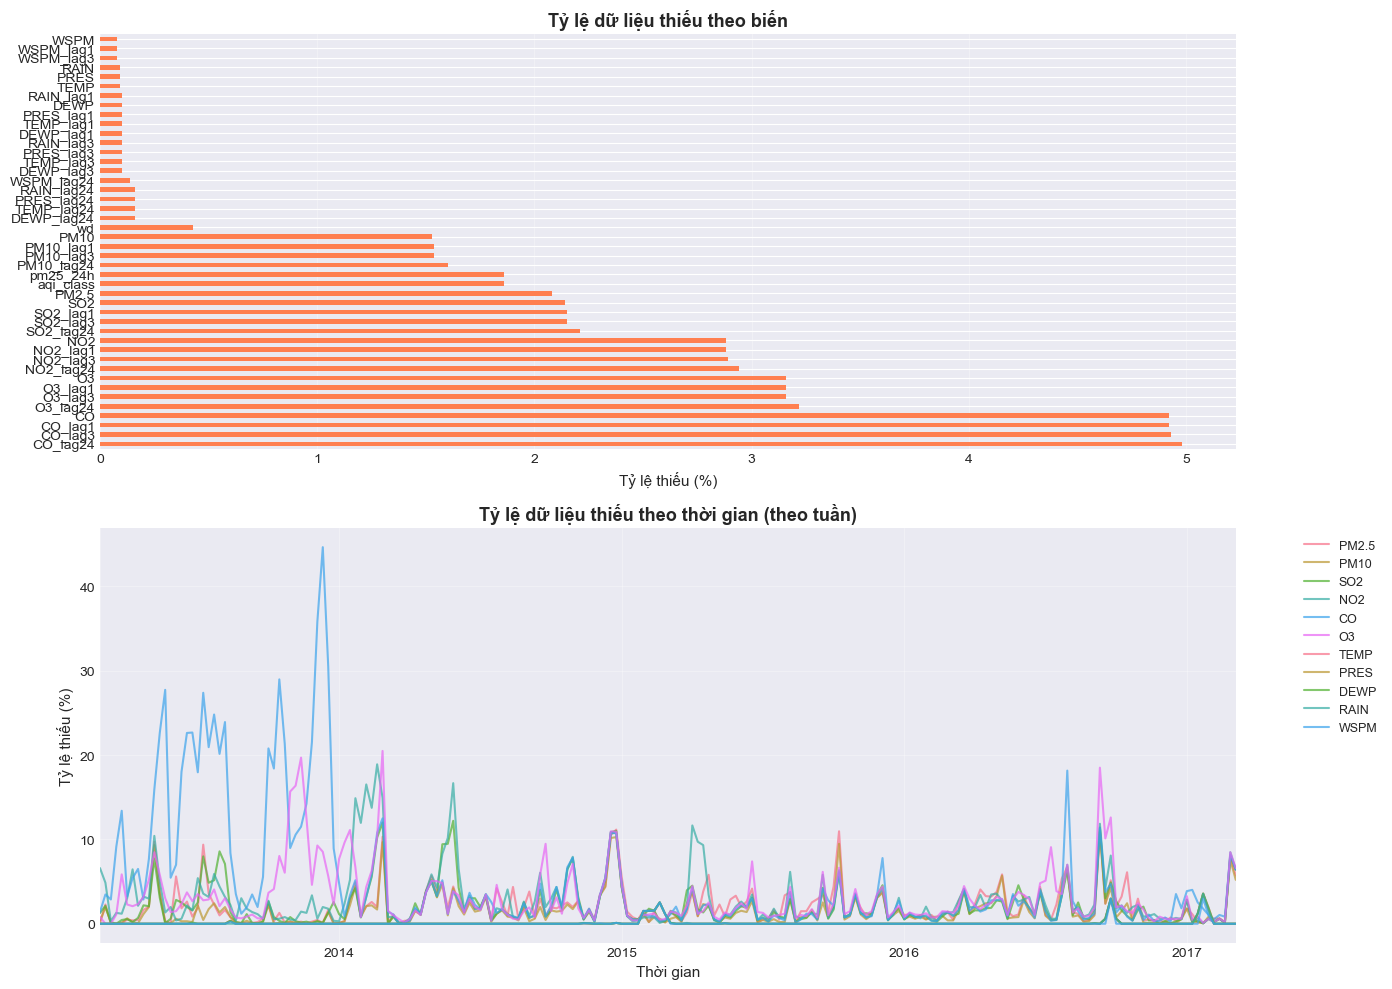


📊 NHẬN XÉT:
- Quan sát đồ thị để xác định:
  + Dữ liệu thiếu tập trung vào giai đoạn nào?
  + Hay dữ liệu thiếu rải đều trong suốt thời gian quan sát?
  + Có xu hướng tăng/giảm tỷ lệ thiếu theo thời gian không?


In [7]:
# Visualize missing data
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Biểu đồ tỷ lệ thiếu theo biến
missing_pct_plot = missing_pct[missing_pct > 0]
if len(missing_pct_plot) > 0:
    missing_pct_plot.plot(kind='barh', ax=axes[0], color='coral')
    axes[0].set_xlabel('Tỷ lệ thiếu (%)', fontsize=11)
    axes[0].set_title('Tỷ lệ dữ liệu thiếu theo biến', fontsize=13, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

# 2. Missing over time
pollutant_weather_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
available_cols = [col for col in pollutant_weather_cols if col in df.columns]

df_missing_time = df.set_index('datetime').resample('W')[available_cols].apply(
    lambda x: x.isna().mean() * 100
)

df_missing_time.plot(ax=axes[1], alpha=0.7, linewidth=1.5)
axes[1].set_ylabel('Tỷ lệ thiếu (%)', fontsize=11)
axes[1].set_xlabel('Thời gian', fontsize=11)
axes[1].set_title('Tỷ lệ dữ liệu thiếu theo thời gian (theo tuần)', fontsize=13, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 NHẬN XÉT:")
print("- Quan sát đồ thị để xác định:")
print("  + Dữ liệu thiếu tập trung vào giai đoạn nào?")
print("  + Hay dữ liệu thiếu rải đều trong suốt thời gian quan sát?")
print("  + Có xu hướng tăng/giảm tỷ lệ thiếu theo thời gian không?")

## 3. Phân tích ngoại lai (Outliers) và phân phối

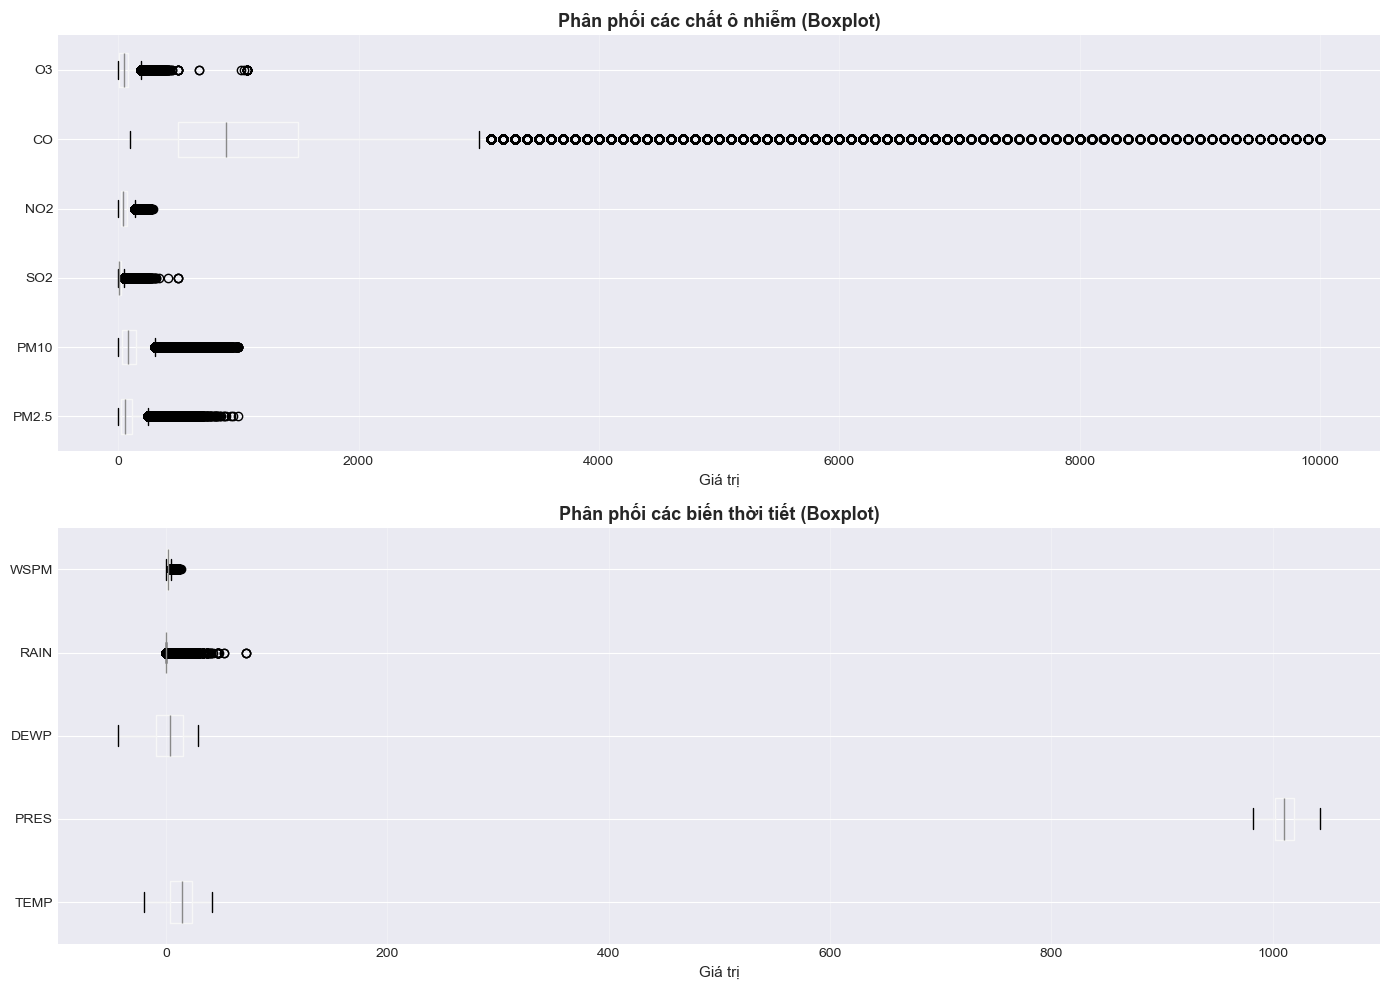


📊 NHẬN XÉT BOXPLOT:
- Các điểm nằm ngoài whiskers là outliers tiềm năng
- Box dài → phân phối rộng, biến động lớn
- Median lệch khỏi trung tâm box → phân phối lệch (skewed)


In [8]:
# Boxplot để phát hiện outliers
pollutant_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
weather_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Lọc các cột tồn tại
pollutant_cols = [col for col in pollutant_cols if col in df.columns]
weather_cols = [col for col in weather_cols if col in df.columns]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Boxplot cho các chất ô nhiễm
if pollutant_cols:
    df[pollutant_cols].boxplot(ax=axes[0], vert=False)
    axes[0].set_title('Phân phối các chất ô nhiễm (Boxplot)', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Giá trị', fontsize=11)
    axes[0].grid(axis='x', alpha=0.3)

# Boxplot cho các biến thời tiết
if weather_cols:
    df[weather_cols].boxplot(ax=axes[1], vert=False)
    axes[1].set_title('Phân phối các biến thời tiết (Boxplot)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Giá trị', fontsize=11)
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 NHẬN XÉT BOXPLOT:")
print("- Các điểm nằm ngoài whiskers là outliers tiềm năng")
print("- Box dài → phân phối rộng, biến động lớn")
print("- Median lệch khỏi trung tâm box → phân phối lệch (skewed)")

In [9]:
# Quantile analysis chi tiết cho PM2.5
print("=" * 70)
print("PHÂN TÍCH QUANTILE CHO PM2.5")
print("=" * 70)

quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
pm25_quantiles = df['PM2.5'].quantile(quantiles)
print("\nPhân vị:")
print(pm25_quantiles)

# Tính IQR và ngưỡng outlier
q1, q3 = pm25_quantiles[0.25], pm25_quantiles[0.75]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"\nIQR (Q3 - Q1): {iqr:.2f}")
print(f"\nNgưỡng outlier (phương pháp 1.5*IQR):")
print(f"  Lower bound: {lower_bound:.2f}")
print(f"  Upper bound: {upper_bound:.2f}")

# Đếm outliers
outliers = df[(df['PM2.5'] < lower_bound) | (df['PM2.5'] > upper_bound)]
print(f"\nSố lượng outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")

# Skewness và Kurtosis
print(f"\nSkewness (độ lệch): {df['PM2.5'].skew():.3f}")
print(f"  → {'Lệch phải (right-skewed)' if df['PM2.5'].skew() > 0 else 'Lệch trái (left-skewed)'}")
print(f"\nKurtosis (độ nhọn): {df['PM2.5'].kurtosis():.3f}")
print(f"  → {'Nhiều outliers' if df['PM2.5'].kurtosis() > 0 else 'Ít outliers hơn phân phối chuẩn'}")

PHÂN TÍCH QUANTILE CHO PM2.5

Phân vị:
0.01      3.0
0.05      6.0
0.10      9.0
0.25     20.0
0.50     55.0
0.75    111.0
0.90    185.0
0.95    242.0
0.99    370.0
Name: PM2.5, dtype: float64

IQR (Q3 - Q1): 91.00

Ngưỡng outlier (phương pháp 1.5*IQR):
  Lower bound: -116.50
  Upper bound: 247.50

Số lượng outliers: 19,142 (4.55%)

Skewness (độ lệch): 2.014
  → Lệch phải (right-skewed)

Kurtosis (độ nhọn): 5.965
  → Nhiều outliers


## 4. Trực quan hóa chuỗi thời gian PM2.5

Đang vẽ chuỗi thời gian toàn bộ giai đoạn...
Đang vẽ chuỗi thời gian chi tiết 2 tháng...


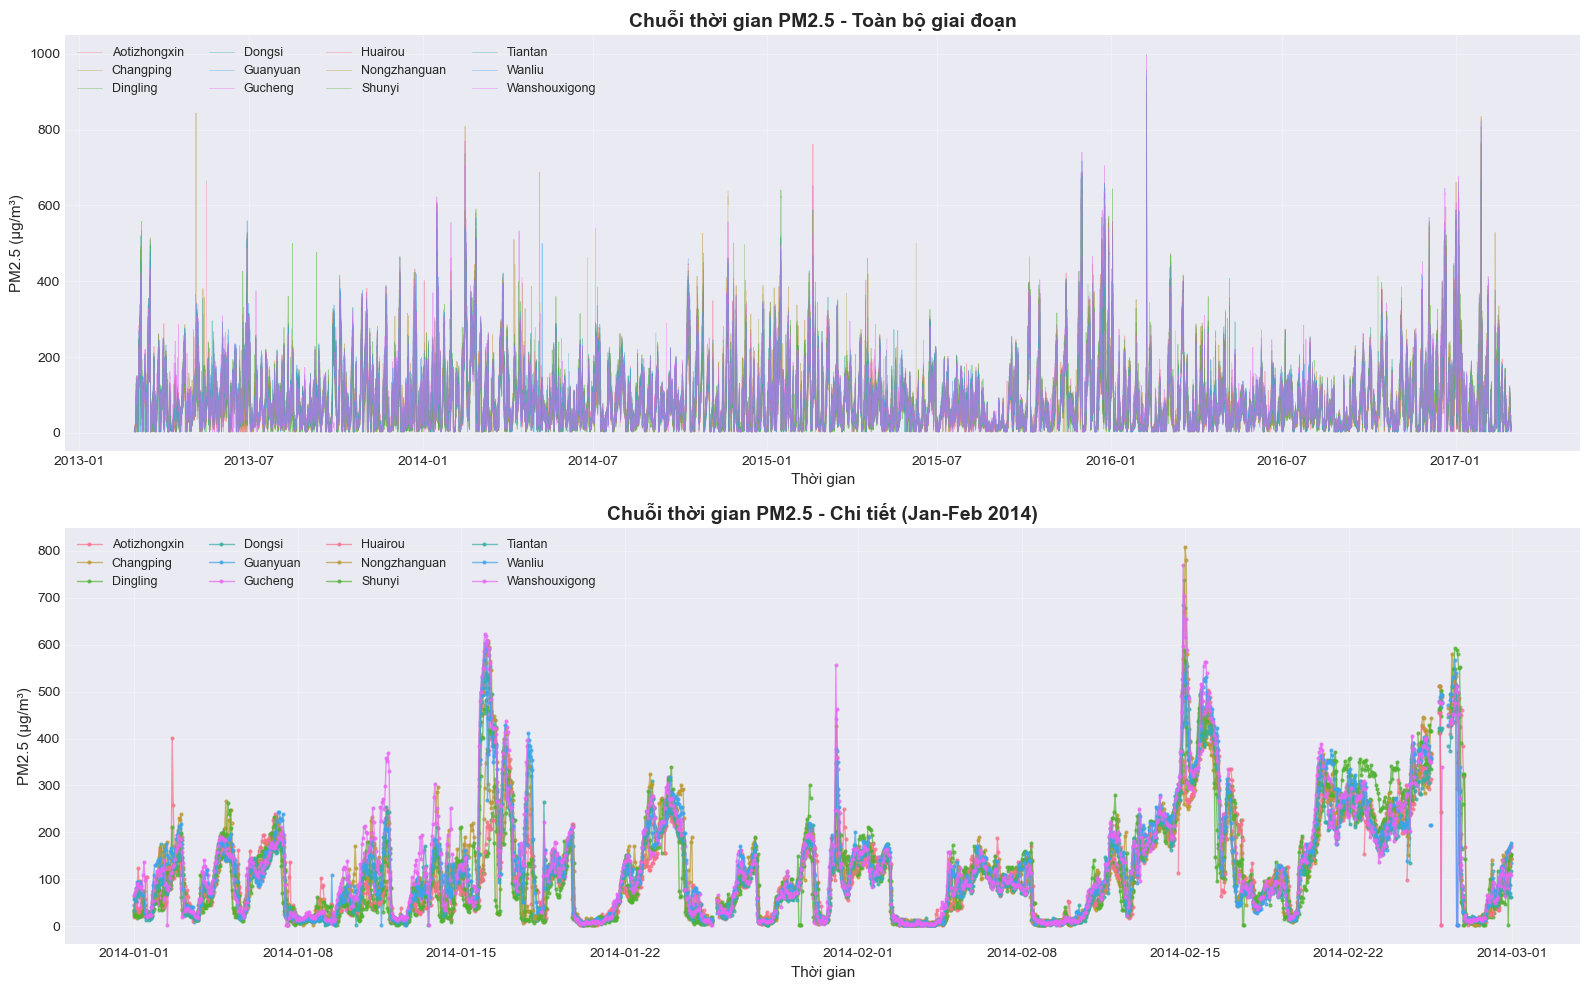


📊 QUAN SÁT:
Từ đồ thị trên, hãy quan sát:
- Xu hướng dài hạn (trend): Tăng, giảm hay ổn định?
- Tính mùa vụ (seasonality): Có chu kỳ theo mùa không?
- Dao động ngắn hạn: Biến động theo ngày/tuần như thế nào?
- Outliers: Có đợt ô nhiễm cực đoan nào không?


In [10]:
# Vẽ chuỗi PM2.5 theo thời gian
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. Toàn bộ giai đoạn
print("Đang vẽ chuỗi thời gian toàn bộ giai đoạn...")
for station in df['station'].unique():
    df_station = df[df['station'] == station].sort_values('datetime')
    axes[0].plot(df_station['datetime'], df_station['PM2.5'], 
                 alpha=0.5, linewidth=0.5, label=station)

axes[0].set_title('Chuỗi thời gian PM2.5 - Toàn bộ giai đoạn', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[0].legend(ncol=4, fontsize=9, loc='upper left')
axes[0].grid(alpha=0.3)
axes[0].set_xlabel('Thời gian', fontsize=11)

# 2. Phóng to 2 tháng (Jan-Feb 2014)
print("Đang vẽ chuỗi thời gian chi tiết 2 tháng...")
zoom_start = pd.Timestamp('2014-01-01')
zoom_end = pd.Timestamp('2014-03-01')
df_zoom = df[(df['datetime'] >= zoom_start) & (df['datetime'] < zoom_end)]

for station in df_zoom['station'].unique():
    df_station = df_zoom[df_zoom['station'] == station].sort_values('datetime')
    axes[1].plot(df_station['datetime'], df_station['PM2.5'], 
                 alpha=0.7, linewidth=1, label=station, marker='o', markersize=2)

axes[1].set_title('Chuỗi thời gian PM2.5 - Chi tiết (Jan-Feb 2014)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Thời gian', fontsize=11)
axes[1].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1].legend(ncol=4, fontsize=9, loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 QUAN SÁT:")
print("Từ đồ thị trên, hãy quan sát:")
print("- Xu hướng dài hạn (trend): Tăng, giảm hay ổn định?")
print("- Tính mùa vụ (seasonality): Có chu kỳ theo mùa không?")
print("- Dao động ngắn hạn: Biến động theo ngày/tuần như thế nào?")
print("- Outliers: Có đợt ô nhiễm cực đoan nào không?")

## 5. Kiểm tra tự tương quan (Autocorrelation)

In [11]:
print("=" * 70)
print("TỰ TƯƠNG QUAN PM2.5")
print("=" * 70)

# Chọn 1 trạm để phân tích (hoặc có thể trung bình tất cả)
station_name = df['station'].unique()[0]
print(f"\nPhân tích cho trạm: {station_name}")

df_one_station = df[df['station'] == station_name].sort_values('datetime').copy()
pm25_series = df_one_station['PM2.5'].dropna()

print(f"Số quan sát: {len(pm25_series):,}")

# Tính tương quan với các độ trễ
lags = [1, 3, 6, 12, 24, 48, 72, 168]  # giờ (168h = 1 tuần)

autocorr_results = {}
for lag in lags:
    if len(pm25_series) > lag:
        corr = pm25_series.autocorr(lag=lag)
        autocorr_results[f'{lag}h'] = corr
        
autocorr_df = pd.DataFrame.from_dict(autocorr_results, orient='index', 
                                      columns=['Correlation'])
print("\nHệ số tự tương quan:")
print(autocorr_df)

TỰ TƯƠNG QUAN PM2.5

Phân tích cho trạm: Aotizhongxin
Số quan sát: 34,139

Hệ số tự tương quan:
      Correlation
1h       0.966572
3h       0.878501
6h       0.759069
12h      0.591005
24h      0.393293
48h      0.136408
72h      0.059083
168h     0.016149


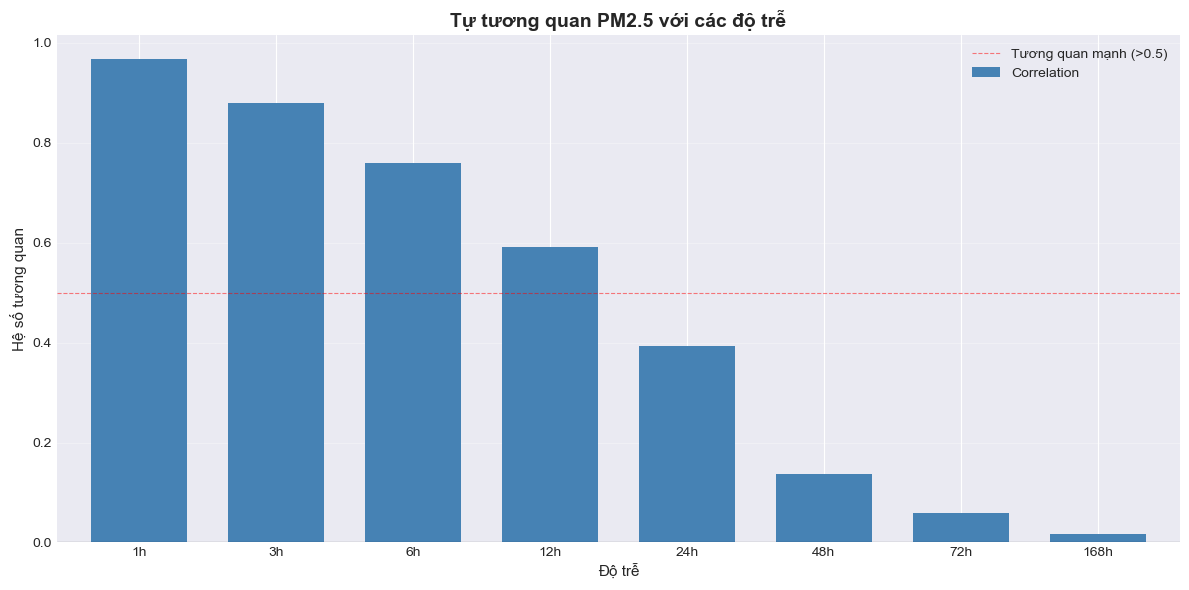


PHÂN TÍCH TỰ TƯƠNG QUAN

📊 Chu kỳ NGÀY (24 giờ):
   Tương quan: 0.393
   ⚠️ Chu kỳ ngày yếu → PM2.5 biến động không theo pattern hàng ngày

📊 Chu kỳ TUẦN (168 giờ):
   Tương quan: 0.016
   ⚠️ Chu kỳ tuần yếu → Không có pattern rõ ràng theo tuần

📊 Tương quan lag ngắn (1-12h):
   Trung bình: 0.799
   ✓ Tương quan rất cao → Chuỗi có tính dự đoán tốt từ giá trị quá khứ gần
   → Lag features rất hữu ích cho mô hình


In [12]:
# Visualize autocorrelation
fig, ax = plt.subplots(figsize=(12, 6))
autocorr_df.plot(kind='bar', ax=ax, legend=False, color='steelblue', width=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Tương quan mạnh (>0.5)')
ax.set_title('Tự tương quan PM2.5 với các độ trễ', fontsize=14, fontweight='bold')
ax.set_xlabel('Độ trễ', fontsize=11)
ax.set_ylabel('Hệ số tương quan', fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("PHÂN TÍCH TỰ TƯƠNG QUAN")
print("=" * 70)

# Phân tích theo chu kỳ
corr_24h = autocorr_results.get('24h', 0)
corr_168h = autocorr_results.get('168h', 0)

print(f"\n📊 Chu kỳ NGÀY (24 giờ):")
print(f"   Tương quan: {corr_24h:.3f}")
if corr_24h > 0.5:
    print("   ✓ Có chu kỳ ngày rõ ràng → PM2.5 hôm nay ảnh hưởng mạnh đến ngày mai")
else:
    print("   ⚠️ Chu kỳ ngày yếu → PM2.5 biến động không theo pattern hàng ngày")

print(f"\n📊 Chu kỳ TUẦN (168 giờ):")
print(f"   Tương quan: {corr_168h:.3f}")
if corr_168h > 0.3:
    print("   ✓ Có chu kỳ tuần → Pattern lặp lại theo tuần (có thể do hoạt động con người)")
else:
    print("   ⚠️ Chu kỳ tuần yếu → Không có pattern rõ ràng theo tuần")

print(f"\n📊 Tương quan lag ngắn (1-12h):")
short_lags = [f'{h}h' for h in [1, 3, 6, 12] if f'{h}h' in autocorr_results]
avg_short_corr = np.mean([autocorr_results[lag] for lag in short_lags])
print(f"   Trung bình: {avg_short_corr:.3f}")
if avg_short_corr > 0.7:
    print("   ✓ Tương quan rất cao → Chuỗi có tính dự đoán tốt từ giá trị quá khứ gần")
    print("   → Lag features rất hữu ích cho mô hình")
else:
    print("   ⚠️ Tương quan thấp → Chuỗi có nhiễu hoặc biến động cao")

## 6. Kiểm tra tính dừng (Stationarity Tests)

In [13]:
# Lấy dữ liệu PM2.5 không thiếu
pm25_clean = pm25_series.copy()

print("=" * 70)
print("KIỂM TRA TÍNH DỪNG")
print("=" * 70)
print(f"\nSố quan sát: {len(pm25_clean):,}")
print(f"Trạm: {station_name}")

# 1. Augmented Dickey-Fuller Test (ADF)
print("\n" + "=" * 70)
print("1. ADF TEST (Augmented Dickey-Fuller)")
print("=" * 70)
print("\nGiả thuyết:")
print("  H0: Chuỗi KHÔNG DỪNG (có unit root)")
print("  H1: Chuỗi DỪNG (stationary)")
print("  → Bác bỏ H0 khi p-value < 0.05")

adf_result = adfuller(pm25_clean, autolag='AIC')

print(f"\nKết quả:")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Lags sử dụng: {adf_result[2]}")
print(f"  Số quan sát: {adf_result[3]}")
print(f"\n  Critical values:")
for key, value in adf_result[4].items():
    print(f"    {key:>5}: {value:>8.4f}")
    
print("\n  Kết luận ADF:")
if adf_result[1] < 0.05:
    print("  ✓ p-value < 0.05 → BÁC BỎ H0")
    print("  → Chuỗi DỪNG (stationary)")
    adf_conclusion = "stationary"
else:
    print("  ✗ p-value ≥ 0.05 → KHÔNG BÁC BỎ H0")
    print("  → Chuỗi KHÔNG DỪNG (non-stationary)")
    adf_conclusion = "non-stationary"

KIỂM TRA TÍNH DỪNG

Số quan sát: 34,139
Trạm: Aotizhongxin

1. ADF TEST (Augmented Dickey-Fuller)

Giả thuyết:
  H0: Chuỗi KHÔNG DỪNG (có unit root)
  H1: Chuỗi DỪNG (stationary)
  → Bác bỏ H0 khi p-value < 0.05

Kết quả:
  ADF Statistic: -19.5261
  p-value: 0.0000
  Lags sử dụng: 39
  Số quan sát: 34099

  Critical values:
       1%:  -3.4305
       5%:  -2.8616
      10%:  -2.5668

  Kết luận ADF:
  ✓ p-value < 0.05 → BÁC BỎ H0
  → Chuỗi DỪNG (stationary)


In [14]:
# 2. KPSS Test
print("\n" + "=" * 70)
print("2. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)")
print("=" * 70)
print("\nGiả thuyết:")
print("  H0: Chuỗi DỪNG (stationary)")
print("  H1: Chuỗi KHÔNG DỪNG (non-stationary)")
print("  → Bác bỏ H0 khi p-value < 0.05")

kpss_result = kpss(pm25_clean, regression='c', nlags='auto')

print(f"\nKết quả:")
print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
print(f"  p-value: {kpss_result[1]:.4f}")
print(f"  Lags sử dụng: {kpss_result[2]}")
print(f"\n  Critical values:")
for key, value in kpss_result[3].items():
    print(f"    {key:>5}: {value:>8.4f}")
    
print("\n  Kết luận KPSS:")
if kpss_result[1] > 0.05:
    print("  ✓ p-value > 0.05 → KHÔNG BÁC BỎ H0")
    print("  → Chuỗi DỪNG (stationary)")
    kpss_conclusion = "stationary"
else:
    print("  ✗ p-value ≤ 0.05 → BÁC BỎ H0")
    print("  → Chuỗi KHÔNG DỪNG (non-stationary)")
    kpss_conclusion = "non-stationary"


2. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)

Giả thuyết:
  H0: Chuỗi DỪNG (stationary)
  H1: Chuỗi KHÔNG DỪNG (non-stationary)
  → Bác bỏ H0 khi p-value < 0.05

Kết quả:
  KPSS Statistic: 0.2008
  p-value: 0.1000
  Lags sử dụng: 105

  Critical values:
      10%:   0.3470
       5%:   0.4630
     2.5%:   0.5740
       1%:   0.7390

  Kết luận KPSS:
  ✓ p-value > 0.05 → KHÔNG BÁC BỎ H0
  → Chuỗi DỪNG (stationary)


C:\Users\binhn\AppData\Local\Temp\ipykernel_16132\1221778367.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(pm25_clean, regression='c', nlags='auto')


In [15]:
# Kết luận tổng hợp
print("\n" + "=" * 70)
print("KẾT LUẬN TỔNG HỢP VỀ TÍNH DỪNG")
print("=" * 70)

print(f"\nADF Test:  {adf_conclusion.upper()}")
print(f"KPSS Test: {kpss_conclusion.upper()}")

print("\n" + "-" * 70)

if adf_conclusion == "stationary" and kpss_conclusion == "stationary":
    print("✓✓ CHUỖI PM2.5 LÀ DỪNG (STATIONARY)")
    print("\n📊 Ý nghĩa:")
    print("  - Mean, variance ổn định theo thời gian")
    print("  - Không có trend dài hạn")
    print("  - CÓ THỂ áp dụng trực tiếp các mô hình:")
    print("    + ARIMA với d=0")
    print("    + Regression trực tiếp")
    print("    + Machine Learning models")
    
elif adf_conclusion == "non-stationary" and kpss_conclusion == "non-stationary":
    print("✗✗ CHUỖI PM2.5 KHÔNG DỪNG (NON-STATIONARY)")
    print("\n📊 Ý nghĩa:")
    print("  - Mean, variance thay đổi theo thời gian")
    print("  - Có trend hoặc seasonality")
    print("  - CẦN xử lý trước khi modeling:")
    print("    + Differencing: df['PM2.5_diff'] = df['PM2.5'].diff()")
    print("    + Detrending: loại bỏ trend tuyến tính")
    print("    + Log transform: giảm variance")
    print("    + ARIMA với d>0 (tích hợp differencing)")
    
else:
    print("⚠️ KẾT QUẢ KHÔNG NHẤT QUÁN")
    print(f"  ADF: {adf_conclusion}")
    print(f"  KPSS: {kpss_conclusion}")
    print("\n📊 Giải thích:")
    print("  - Có thể do:")
    print("    + Chuỗi có cả trend và mean-reverting")
    print("    + Structural breaks trong dữ liệu")
    print("    + Seasonality phức tạp")
    print("\n💡 Khuyến nghị:")
    print("  - Kiểm tra visual bằng đồ thị rolling mean/std")
    print("  - Thử differencing và test lại")
    print("  - Xem xét seasonal decomposition")
    print("  - An toàn: áp dụng differencing d=1 cho ARIMA")

print("\n" + "=" * 70)


KẾT LUẬN TỔNG HỢP VỀ TÍNH DỪNG

ADF Test:  STATIONARY
KPSS Test: STATIONARY

----------------------------------------------------------------------
✓✓ CHUỖI PM2.5 LÀ DỪNG (STATIONARY)

📊 Ý nghĩa:
  - Mean, variance ổn định theo thời gian
  - Không có trend dài hạn
  - CÓ THỂ áp dụng trực tiếp các mô hình:
    + ARIMA với d=0
    + Regression trực tiếp
    + Machine Learning models



## 7. Phân tích biến thiếu quan trọng cho dự báo PM2.5

**Câu hỏi:** Thiếu theo biến nào là đáng lo nhất cho dự báo PM2.5 và vì sao?

In [16]:
print("=" * 70)
print("PHÂN TÍCH MỨC ĐỘ QUAN TRỌNG CỦA CÁC BIẾN")
print("=" * 70)

# Các biến tiềm năng
feature_cols = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
available_features = [col for col in feature_cols if col in df.columns]

# Tính correlation với PM2.5
correlations = df[['PM2.5'] + available_features].corr()['PM2.5'].abs().sort_values(ascending=False)

print("\nTương quan tuyệt đối với PM2.5:")
print(correlations[1:])  # Bỏ PM2.5 với chính nó

PHÂN TÍCH MỨC ĐỘ QUAN TRỌNG CỦA CÁC BIẾN

Tương quan tuyệt đối với PM2.5:
PM10    0.884380
CO      0.789998
NO2     0.666948
SO2     0.482354
WSPM    0.272205
O3      0.149697
TEMP    0.131127
DEWP    0.114656
PRES    0.018566
RAIN    0.014359
Name: PM2.5, dtype: float64


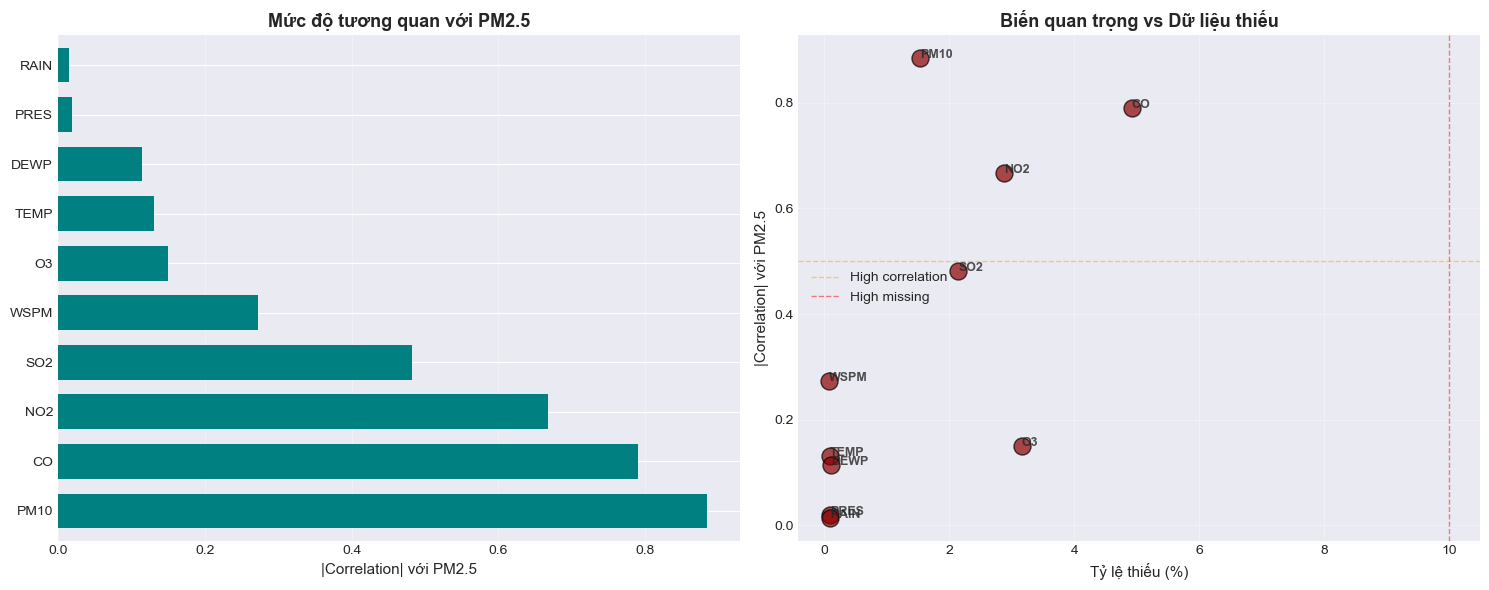

In [17]:
# Visualize correlation và missing rate
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Correlation bar chart
correlations[1:].plot(kind='barh', ax=axes[0], color='teal', width=0.7)
axes[0].set_xlabel('|Correlation| với PM2.5', fontsize=11)
axes[0].set_title('Mức độ tương quan với PM2.5', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# 2. Missing rate vs importance
importance_vs_missing = pd.DataFrame({
    'Missing_Rate_%': missing_pct[correlations[1:].index],
    'Abs_Correlation': correlations[1:]
})

importance_vs_missing.plot(kind='scatter', x='Missing_Rate_%', y='Abs_Correlation', 
                            s=150, alpha=0.7, ax=axes[1], color='darkred', edgecolors='black')

# Annotate points
for idx, row in importance_vs_missing.iterrows():
    axes[1].annotate(idx, (row['Missing_Rate_%'], row['Abs_Correlation']), 
                     fontsize=9, alpha=0.8, fontweight='bold')

# Thêm vùng risk cao
axes[1].axhline(y=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='High correlation')
axes[1].axvline(x=10, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High missing')

axes[1].set_xlabel('Tỷ lệ thiếu (%)', fontsize=11)
axes[1].set_ylabel('|Correlation| với PM2.5', fontsize=11)
axes[1].set_title('Biến quan trọng vs Dữ liệu thiếu', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Tính risk score
print("\n" + "=" * 70)
print("PHÂN TÍCH RISK SCORE")
print("=" * 70)
print("\nRisk Score = |Correlation| × Missing_Rate%")
print("→ Biến quan trọng (correlation cao) MÀ thiếu nhiều = Risk cao")

importance_vs_missing['risk_score'] = (
    importance_vs_missing['Abs_Correlation'] * importance_vs_missing['Missing_Rate_%']
)

importance_vs_missing_sorted = importance_vs_missing.sort_values('risk_score', ascending=False)
print("\nBảng xếp hạng risk:")
print(importance_vs_missing_sorted)

# Top 3 biến đáng lo nhất
top_risk = importance_vs_missing_sorted.head(3)

print("\n" + "=" * 70)
print("🔴 TOP 3 BIẾN ĐÁNG LO NHẤT")
print("=" * 70)

for i, (var, row) in enumerate(top_risk.iterrows(), 1):
    print(f"\n{i}. {var}")
    print(f"   ├─ Tương quan với PM2.5: {row['Abs_Correlation']:.3f}")
    print(f"   ├─ Tỷ lệ thiếu: {row['Missing_Rate_%']:.2f}%")
    print(f"   └─ Risk score: {row['risk_score']:.2f}")


PHÂN TÍCH RISK SCORE

Risk Score = |Correlation| × Missing_Rate%
→ Biến quan trọng (correlation cao) MÀ thiếu nhiều = Risk cao

Bảng xếp hạng risk:
      Missing_Rate_%  Abs_Correlation  risk_score
CO              4.92         0.789998    3.886789
NO2             2.88         0.666948    1.920811
PM10            1.53         0.884380    1.353101
SO2             2.14         0.482354    1.032239
O3              3.16         0.149697    0.473041
WSPM            0.08         0.272205    0.021776
TEMP            0.09         0.131127    0.011801
DEWP            0.10         0.114656    0.011466
PRES            0.09         0.018566    0.001671
RAIN            0.09         0.014359    0.001292

🔴 TOP 3 BIẾN ĐÁNG LO NHẤT

1. CO
   ├─ Tương quan với PM2.5: 0.790
   ├─ Tỷ lệ thiếu: 4.92%
   └─ Risk score: 3.89

2. NO2
   ├─ Tương quan với PM2.5: 0.667
   ├─ Tỷ lệ thiếu: 2.88%
   └─ Risk score: 1.92

3. PM10
   ├─ Tương quan với PM2.5: 0.884
   ├─ Tỷ lệ thiếu: 1.53%
   └─ Risk score: 1.35


In [19]:
# Giải thích chi tiết
print("\n" + "=" * 70)
print("💡 GIẢI THÍCH CHI TIẾT")
print("=" * 70)

explanations = {
    'PM10': {
        'why_important': 'Có tương quan RẤT CAO với PM2.5 (cùng loại chất ô nhiễm hạt)',
        'why_critical': 'PM10 và PM2.5 có nguồn phát sinh tương tự và biến động cùng chiều',
        'impact': 'Thiếu PM10 → Mất thông tin dự báo quan trọng nhất, giảm accuracy đáng kể'
    },
    'DEWP': {
        'why_important': 'Điểm sương phản ánh độ ẩm không khí',
        'why_critical': 'Độ ẩm ảnh hưởng đến khả năng khuếch tán và lắng đọng ô nhiễm',
        'impact': 'Thiếu DEWP → Giảm khả năng mô hình hóa điều kiện khí tượng'
    },
    'TEMP': {
        'why_important': 'Nhiệt độ là yếu tố khí tượng cơ bản',
        'why_critical': 'Điều khiển động lực học khí quyển và phản ứng hóa học',
        'impact': 'Thiếu TEMP → Mất thông tin về điều kiện môi trường cơ bản'
    },
    'PRES': {
        'why_important': 'Áp suất khí quyển ảnh hưởng đến tuần hoàn không khí',
        'why_critical': 'Áp suất thấp → gió mạnh → giảm ô nhiễm; Áp suất cao → ô nhiễm tích tụ',
        'impact': 'Thiếu PRES → Giảm khả năng dự báo điều kiện khuếch tán'
    },
    'SO2': {
        'why_important': 'Chất ô nhiễm liên quan đến đốt nhiên liệu',
        'why_critical': 'Nguồn phát sinh tương tự PM2.5 (công nghiệp, giao thông)',
        'impact': 'Thiếu SO2 → Mất indicator về hoạt động đốt nhiên liệu'
    }
}

for var in top_risk.index:
    if var in explanations:
        print(f"\n🔹 {var}:")
        print(f"   Tại sao quan trọng: {explanations[var]['why_important']}")
        print(f"   Vai trò: {explanations[var]['why_critical']}")
        print(f"   Tác động: {explanations[var]['impact']}")


💡 GIẢI THÍCH CHI TIẾT

🔹 PM10:
   Tại sao quan trọng: Có tương quan RẤT CAO với PM2.5 (cùng loại chất ô nhiễm hạt)
   Vai trò: PM10 và PM2.5 có nguồn phát sinh tương tự và biến động cùng chiều
   Tác động: Thiếu PM10 → Mất thông tin dự báo quan trọng nhất, giảm accuracy đáng kể


In [20]:
# Khuyến nghị
print("\n" + "=" * 70)
print("📊 KHUYẾN NGHỊ XỬ LÝ DỮ LIỆU THIẾU")
print("=" * 70)

print("\n1. ƯU TIÊN CAO (Risk Score > median):")
median_risk = importance_vs_missing['risk_score'].median()
high_risk_vars = importance_vs_missing[importance_vs_missing['risk_score'] > median_risk]
print(f"   Biến: {', '.join(high_risk_vars.index)}")
print("   Phương pháp đề xuất:")
print("   ├─ Interpolation (linear, spline) cho biến liên tục")
print("   ├─ KNN imputation (dùng K-nearest neighbors)")
print("   ├─ Forward/Backward fill cho chuỗi thời gian")
print("   └─ Multiple imputation (MICE) nếu thiếu phức tạp")

print("\n2. ƯU TIÊN TRUNG BÌNH:")
medium_risk_vars = importance_vs_missing[
    (importance_vs_missing['risk_score'] <= median_risk) & 
    (importance_vs_missing['Missing_Rate_%'] > 0)
]
if len(medium_risk_vars) > 0:
    print(f"   Biến: {', '.join(medium_risk_vars.index)}")
    print("   Phương pháp đề xuất:")
    print("   ├─ Mean/Median imputation")
    print("   └─ Forward fill đơn giản")

print("\n3. BIẾN TARGET (PM2.5):")
pm25_missing = missing_pct.get('PM2.5', 0)
print(f"   Tỷ lệ thiếu: {pm25_missing:.2f}%")
print("   Phương pháp:")
print("   ├─ KHÔNG nên impute biến target")
print("   └─ Loại bỏ các quan sát thiếu PM2.5 (dropna)")

print("\n4. LƯU Ý:")
print("   ⚠️ Kiểm tra lại performance sau khi impute")
print("   ⚠️ Xem xét tạo feature 'is_missing' flag")
print("   ⚠️ Với missing rate > 50%: cân nhắc loại bỏ biến")
print("   ⚠️ Document rõ phương pháp imputation đã dùng")

print("\n" + "=" * 70)


📊 KHUYẾN NGHỊ XỬ LÝ DỮ LIỆU THIẾU

1. ƯU TIÊN CAO (Risk Score > median):
   Biến: PM10, CO, NO2, SO2, O3
   Phương pháp đề xuất:
   ├─ Interpolation (linear, spline) cho biến liên tục
   ├─ KNN imputation (dùng K-nearest neighbors)
   ├─ Forward/Backward fill cho chuỗi thời gian
   └─ Multiple imputation (MICE) nếu thiếu phức tạp

2. ƯU TIÊN TRUNG BÌNH:
   Biến: WSPM, TEMP, DEWP, PRES, RAIN
   Phương pháp đề xuất:
   ├─ Mean/Median imputation
   └─ Forward fill đơn giản

3. BIẾN TARGET (PM2.5):
   Tỷ lệ thiếu: 2.08%
   Phương pháp:
   ├─ KHÔNG nên impute biến target
   └─ Loại bỏ các quan sát thiếu PM2.5 (dropna)

4. LƯU Ý:
   ⚠️ Kiểm tra lại performance sau khi impute
   ⚠️ Xem xét tạo feature 'is_missing' flag
   ⚠️ Với missing rate > 50%: cân nhắc loại bỏ biến
   ⚠️ Document rõ phương pháp imputation đã dùng



## Tổng kết

Notebook này đã phân tích đầy đủ các khía cạnh của dữ liệu Beijing Air Quality:

1. ✅ **Khoảng thời gian & tần suất**: Xác định phạm vi thời gian và tính liên tục
2. ✅ **Dữ liệu thiếu**: Phân tích tỷ lệ thiếu theo biến và thời gian
3. ✅ **Outliers**: Boxplot và quantile analysis
4. ✅ **Chuỗi thời gian**: Visualization toàn cảnh và chi tiết
5. ✅ **Tự tương quan**: Kiểm tra chu kỳ ngày/tuần
6. ✅ **Tính dừng**: ADF và KPSS tests
7. ✅ **Biến thiếu quan trọng**: Phân tích risk và khuyến nghị

Các phát hiện chính có thể được sử dụng để:
- Xử lý dữ liệu thiếu hiệu quả
- Chọn features quan trọng cho modeling
- Quyết định cần differencing hay không
- Thiết kế lag features phù hợp